In [1]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import random

In [2]:
original_sequence = ["SLEEPING", "SLEEPING", "SLEEPING", "CRYING", "SLEEPING", "SLEEPING", "CRYING", "SLEEPING", "HAPPY",
                     "HAPPY", "CRYING", "HAPPY", "SLEEPING", "SLEEPING", "CRYING", "HAPPY", "SLEEPING", "HAPPY",
                     "SLEEPING", "CRYING", "SLEEPING", "HAPPY", "SLEEPING", "HAPPY", "SLEEPING", "CRYING", "SLEEPING",
                     "HAPPY", "SLEEPING", "HAPPY", "SLEEPING", "CRYING", "SLEEPING", "HAPPY", "SLEEPING", "HAPPY",
                     "HAPPY", "SLEEPING", "HAPPY", "HAPPY", "SLEEPING", "HAPPY", "HAPPY", "SLEEPING", "HAPPY",
                     "SLEEPING", "SLEEPING", "SLEEPING", "HAPPY", "SLEEPING", "HAPPY", "SLEEPING", "SLEEPING",
                     "HAPPY", "HAPPY", "SLEEPING", "SLEEPING", "SLEEPING", "SLEEPING", "HAPPY", "HAPPY", "SLEEPING",
                     "HAPPY", "SLEEPING", "SLEEPING", "CRYING", "CRYING", "SLEEPING", "SLEEPING", "SLEEPING"]

In [3]:
num_trials = 100
simulated_sequence = original_sequence * num_trials

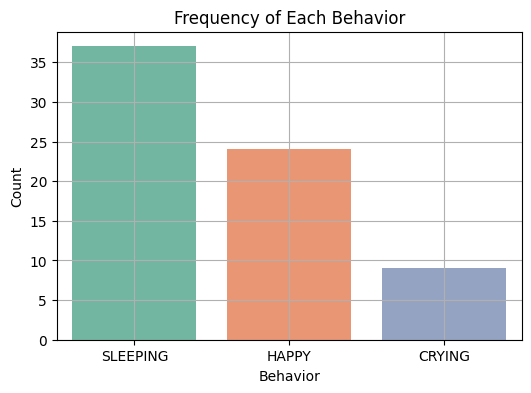

In [4]:
state_counts = pd.Series(original_sequence).value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(
    x=state_counts.index,
    y=state_counts.values,
    hue=state_counts.index,
    palette='Set2',
    dodge=False,
    legend=False
)
plt.title("Frequency of Each Behavior")
plt.ylabel("Count")
plt.xlabel("Behavior")
plt.grid(True)
plt.show()

In [5]:
def build_transition_matrix(sequence):
    transitions = defaultdict(lambda: defaultdict(int))
    for i in range(len(sequence) - 1):
        curr, nxt = sequence[i].lower(), sequence[i+1].lower()
        transitions[curr][nxt] += 1
    matrix = {
        state: {next_state: count / sum(nexts.values()) for next_state, count in nexts.items()}
        for state, nexts in transitions.items()
    }
    return pd.DataFrame(matrix).fillna(0)

transition_df = build_transition_matrix(simulated_sequence)
transition_df.index.name = "Current State"
display(transition_df.round(3))

,sleeping,crying,happy
Current State,,,
sleeping,0.378,0.667,0.708
crying,0.189,0.111,0.042
happy,0.433,0.222,0.250


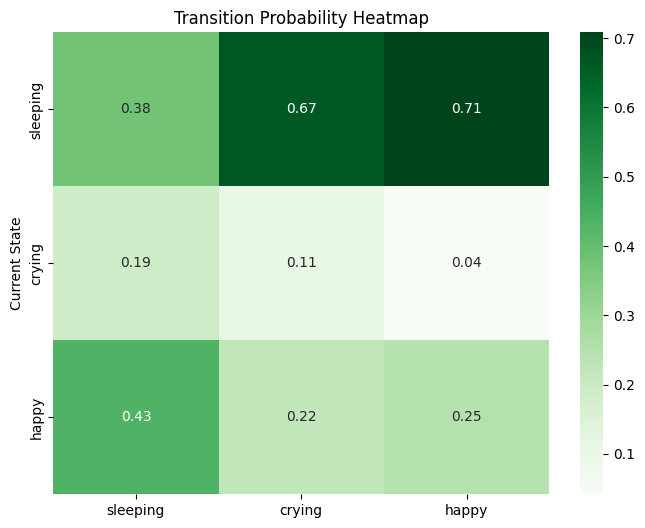

In [6]:
plt.figure(figsize=(8, 6))
sns.heatmap(transition_df, annot=True, fmt=".2f", cmap="Greens")
plt.title("Transition Probability Heatmap")
plt.show()

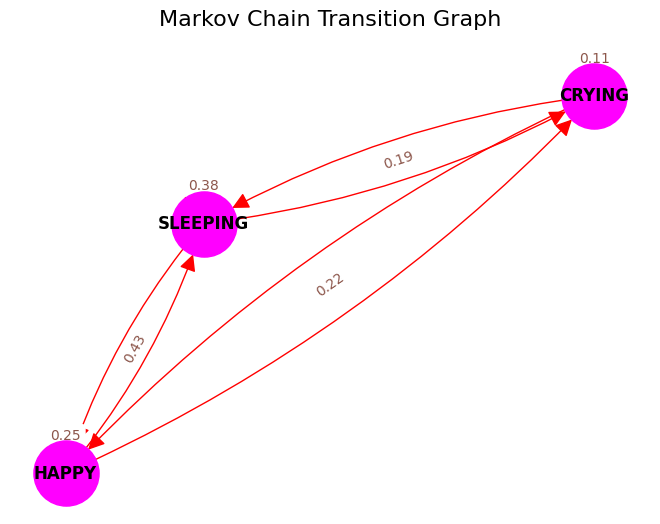

In [7]:
def draw_transition_graph(df):
    G = nx.DiGraph()
    for i in df.index:
        for j in df.columns:
            if df.loc[i, j] > 0:
                G.add_edge(i.upper(), j.upper(), weight=df.loc[i, j])

    pos = nx.spring_layout(G, seed=42)
    edge_weights = nx.get_edge_attributes(G, 'weight')
    edge_labels = {k: f"{v:.2f}" for k, v in edge_weights.items()}

    node_color = "magenta"
    edge_color = "red"

    nx.draw(G, pos,
            with_labels=True,
            node_size=2200,
            node_color=node_color,
            edge_color=edge_color,
            font_size=12,
            font_weight="bold",
            font_color="black",
            arrowsize=25,
            connectionstyle='arc3,rad=0.1')

    nx.draw_networkx_edge_labels(G, pos,
                                edge_labels=edge_labels,
                                font_color="#8c564b",
                                font_size=10,
                                label_pos=0.5)

    plt.title("Markov Chain Transition Graph", fontsize=16)
    plt.axis('off')
    plt.show()

draw_transition_graph(transition_df)

In [8]:
def predict_next_state(current_state, df):
    if current_state not in df.index:
        return None
    return df.loc[current_state].idxmax()

current = "crying"
predicted = predict_next_state(current, transition_df)
print(f"The predicted next behavior after '{current.upper()}' is '{predicted.upper()}'")

The predicted next behavior after 'CRYING' is 'SLEEPING'


Steady state probabilities:


,0
sleeping,0.333
crying,0.333
happy,0.333


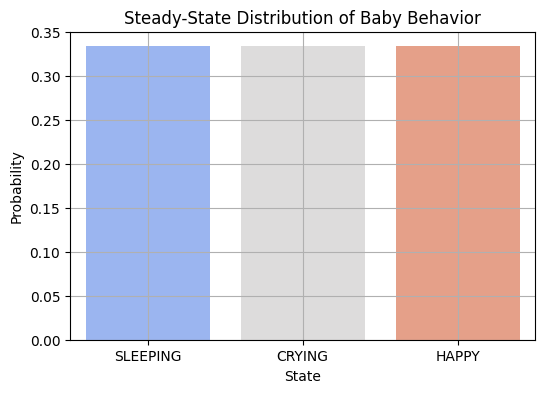

In [9]:
def compute_steady_state(df):
    matrix = df.values.T
    eigvals, eigvecs = np.linalg.eig(matrix)
    index = np.argmin(np.abs(eigvals - 1))
    steady = np.real(eigvecs[:, index])
    steady = steady / steady.sum()
    return pd.Series(steady, index=df.columns)

steady_state = compute_steady_state(transition_df)
print("Steady state probabilities:")
display(steady_state.round(3))

plt.figure(figsize=(6, 4))
sns.barplot(x=steady_state.index.str.upper(), y=steady_state.values, palette='coolwarm',
            hue=steady_state.index.str.upper(), legend=False)
plt.title("Steady-State Distribution of Baby Behavior")
plt.ylabel("Probability")
plt.xlabel("State")
plt.grid(True)
plt.show()